# UK Electricity Demand & Generation Forecasting: Technical Assignment

This notebook demonstrates a workflow for forecasting UK electricity demand using real-world data and machine learning. 

---

## Step-by-Step Structure

### 1. **Business Context & Problem Statement**
- **Business**: Energy trading company with narrow profit margins, relying on accurate short-term demand forecasts.
- **Problem**: The current naive baseline forecast shows significant prediction errors, impacting trading performance.
- **Goal**: Develop and evaluate advanced forecasting models, and test additional features to improve 0–24 hour demand prediction.

---

### 2. **Data Acquisition & Preparation**
- **Datasets**:
    - UK electricity demand (2009–2024)
    - UK electricity generation by source (2009–2024)
- **Data Loading**:
    - Download demand data from Kaggle and generation data from NESO API.
    - Parse, clean, and join both datasets on a common `datetime` column.
- **Preprocessing**:
    - Handle time intervals (settlement periods), missing values, and daylight saving issues.
    - Drop unnecessary columns and ensure consistent datetime formatting.

---

### 3. **Exploratory Data Analysis (EDA)**
- **Visualization**:
    - Plot hourly, daily, weekly, monthly, and yearly averages for demand and generation.
    - Use interactive Plotly charts to explore trends and seasonality.
- **Insights**:
    - Identify patterns, anomalies, and potential feature engineering opportunities.

---

### 4. **Baseline Model Definition**
- **Model**: 7-day mean demand at the same time of day (simple historical average).
- **Evaluation**:
    - Predict demand in rolling 24-hour windows for December 2023.
    - Visualize predictions vs. actuals.
    - Calculate RMSE and MAPE for each 24-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.

---

### 5. **Machine Learning Models**
- **Model 1**: Gradient Boosting Regressor (GBR) with 3 features:
    - Day of week, hour of day, 24 h lagged demand.
- **Model 2**: GBR with 5 features (adds):
    - Day of year, 30 min lagged demand.
- **Training & Testing**:
    - Train on Janurary 2020 – November 2023 data, test on December 2023.
    - Make predictions for rolling 24-hour windows.
    - Calculate RMSE and MAPE for each 24-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.
- **Visualization**:
    - Plot model predictions vs. actuals for each window.

---

### 6. **Model Comparison**
- **Metrics**:
    - Compare RMSE across baseline and both ML models for each day in December 2023.
- **Visualization**:
    - Plot MAPE for all models to highlight improvements from feature engineering.

---

### 7. **Feature Engineering & Further Improvements**
- **Analysis**:
    - Discuss impact of additional features (lags, seasonality).
    - Identify which features most improve forecast accuracy.
- **Next Steps**:
    - Suggest further data sources (weather, market prices, holidays).
    - Propose advanced modeling approaches (e.g., deep learning, exogenous variables).

---

## **Summary**

This notebook provides a reproducible, step-by-step approach to:
- Data ingestion and cleaning
- Exploratory analysis
- Baseline and advanced ML modeling
- Model evaluation and comparison
- Feature engineering insights

It is designed to showcase both technical skills and business understanding for a real-world energy forecasting challenge.

### Imports and Library Setup

Import all the necessary Python libraries and packages for the notebook's workflow.


In [1]:
import os
import time
import shutil
import requests
import kagglehub
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import datetime, timedelta

from lightgbm import LGBMRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

/Users/vadimbogatyr/VSCode/adaptfy_uk_energy/UK-energy/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### UK Electricity Demand Data Acquisition and Preparation

Downloading the data from Kaggle (https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data). 

The time is stored in 'settlement_period' as 1-48 30-minute windows. I convert them to hours and minutes, merge with date to make datetime format column.

In [ ]:
# Download all UK electricity demand files from Kaggle dataset
path = kagglehub.dataset_download("albertovidalrod/electricity-consumption-uk-20092022")
print("Path to dataset files:", path)

# Copy historic_demand_2009_2024.csv to data folder in the parent directory (where notebooks folder is)
csv_name = "historic_demand_2009_2024.csv"
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, "data")
os.makedirs(data_dir, exist_ok=True)
src = os.path.join(path, csv_name)
dst = os.path.join(data_dir, csv_name)
shutil.copy(src, dst)
print(f"Copied {csv_name} to data folder: {dst}")

# Read CSV directly with Polars
df_dmnd = pl.read_csv(dst)

# Calculate datetime for each settlement_period (1-24, each is a 30-min interval)
df_dmnd = df_dmnd.with_columns(
    (pl.col('settlement_date') + " " + pl.format("{}:{}", 
        ((pl.col('settlement_period') - 1) * 30 // 60).cast(pl.Utf8).str.zfill(2),
        ((pl.col('settlement_period') - 1) * 30 % 60).cast(pl.Utf8).str.zfill(2)
    )).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False).alias('datetime')
)

# Drop rows where datetime is null (due to day-time saving time issues)
df_dmnd = df_dmnd.filter(pl.col('datetime').is_not_null())

# Sort by datetime (Polars does not have a true index)
df_dmnd = df_dmnd.sort('datetime')

# Drop unwanted columns
cols_to_drop = ["settlement_period", "settlement_date", ""] 
df_dmnd = df_dmnd.drop(cols_to_drop)

# Reorder columns to have datetime first
cols = ['datetime'] + [col for col in df_dmnd.columns if col != 'datetime']
df_dmnd = df_dmnd.select(cols)

print("Demand DataFrame columns:", df_dmnd.columns)
print(df_dmnd.head(10))



Path to dataset files: /Users/vadimbogatyr/.cache/kagglehub/datasets/albertovidalrod/electricity-consumption-uk-20092022/versions/85
Copied historic_demand_2009_2024.csv to data folder: /Users/vadimbogatyr/VSCode/adaptfy_uk_energy/UK-energy/data/historic_demand_2009_2024.csv
Demand DataFrame columns: ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']
shape: (10, 22)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd   ┆ england_wa ┆ … ┆ scottish_t ┆ viking_flo ┆ greenlink_ ┆ is_holiday │
│ ---         ┆ ---   ┆ ---   ┆ les_demand ┆   ┆ ransfer    ┆ w          ┆ flow       ┆ ---       

### UK Electricity Generation Data Acquisition and Preparation

NESO Energy data: https://www.neso.energy/data-portal/historic-generation-mix/historic_gb_generation_mix#

Retrieve electricity generation data using API. Parse and clean the data.

In [4]:
# NESO energy generation mix resource_id from the example
resource_id = "f93d1835-75bc-43e5-84ad-12472b180a98"

# CKAN API endpoint
url = "https://api.neso.energy/api/3/action/datastore_search"

# Query parameters
params = {
    "resource_id": resource_id,
    "limit": 500000  # Adjust limit as needed
}

response = requests.get(url, params=params)
data = response.json()

# Convert records to Polars DataFrame
records = data['result']['records']
df_gnrt = pl.DataFrame(records)

# Parse DATETIME to polars datetime
df_gnrt = df_gnrt.with_columns(
    pl.col("DATETIME").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S", strict=False).alias("datetime")
)

# Split into date and time columns
df_gnrt = df_gnrt.with_columns([
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("date"),
    pl.col("datetime").dt.strftime("%H:%M").alias("time")
])

# Drop 'DATETIME', '_id', and any Unnamed columns
cols_to_drop = ["DATETIME", "_id", "date", "time"]
df_gnrt = df_gnrt.drop(cols_to_drop)

# Lowercase all column names
df_gnrt.columns = [col.lower() for col in df_gnrt.columns]

# Bring 'datetime' to the beginning
df_gnrt = df_gnrt.select(["datetime"] + [col for col in df_gnrt.columns if col != "datetime"])

print("Demand DataFrame columns:", df_gnrt.columns)
print(df_gnrt.head(10))

print("Dataframe shape:", df_gnrt.shape)

# Save to CSV in the data folder (in the same folder as the notebooks folder)
gen_csv_name = "historic_generation_2009_2024.csv"
gen_csv_path = os.path.join(parent_dir, "data", gen_csv_name)
df_gnrt.write_csv(gen_csv_path)
print(f"Saved generation data to: {gen_csv_path}")

Demand DataFrame columns: ['datetime', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (10, 34)
┌─────────────┬────────┬──────┬─────────┬───┬─────────────┬─────────────┬─────────────┬────────────┐
│ datetime    ┆ gas    ┆ coal ┆ nuclear ┆ … ┆ low_carbon_ ┆ zero_carbon ┆ renewable_p ┆ fossil_per │
│ ---         ┆ ---    ┆ ---  ┆ ---     ┆   ┆ perc        ┆ _perc       ┆ erc         ┆ c          │
│ datetime[μs ┆ f64    ┆ f64  ┆ f64     ┆   ┆ ---         ┆ ---         ┆ ---         ┆ ---        │
│ ]           ┆        ┆      ┆         ┆   ┆ f64         ┆ f64         ┆ f64         ┆ f64      

Merge demand and generation data on the `datetime` column to create a unified DataFrame for analysis.

In [5]:
# Merge the two dataframes on 'datetime'
df = df_dmnd.join(df_gnrt, on=["datetime"], how="inner")
df = df.sort("datetime")

# Print the column names and the header
print("Columns in the new dataframe: ", df.columns)
print(df.head())


Columns in the new dataframe:  ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (5, 55)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd

### Plot Demand and Generation data. 

Reusable function to plot interactive time series of National Demand, Transmission System Demand, and Generation using Plotly. Allows flexible time ranges, labels, and styling for clear comparison of trends.

From the dataset description: https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data

**ND (National Demand)**. National Demand is the sum of metered generation, but excludes generation required to meet station load, pump storage pumping and interconnector exports. National Demand is calculated as a sum of generation based on National Grid ESO operational generation metering. Measured in MW.

**TSD (Transmission System Demand)**. Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

We are going to refer to TSD as demand from here on.


In [6]:
def plot_avg_plotly(
    df_avg,
    x_col,
    start,
    end,
    title,
    xlabel,
    marker_size,
    line_style,
    nd_color='bisque',
    tsd_color='darkorange',
    gen_color='dodgerblue'
):
    
    # Filter the dataframe based on the provided start and end datetime
    df_avg = df_avg.filter((pl.col(x_col) >= start) & (pl.col(x_col) <= end))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['nd'],
        mode=line_style,
        name='National Demand (ND)',
        marker=dict(size=marker_size, color=nd_color),
        line=dict(color=nd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['tsd'],
        mode=line_style,
        name='Transmission System Demand (TSD)',
        marker=dict(size=marker_size, color=tsd_color),
        line=dict(color=tsd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['generation'],
        mode=line_style,
        name='Generation',
        marker=dict(size=marker_size, color=gen_color),
        line=dict(color=gen_color)
    ))
    fig.update_layout(
        title=dict(text=title, font=dict(size=20), x=0.5),
        xaxis_title=xlabel,
        yaxis_title='MW',
        yaxis=dict(range=[0, 60000], title_font=dict(size=18), tickfont=dict(size=16)),
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=16)),
        legend=dict(font=dict(size=15), x=0, y=0, xanchor='left', yanchor='bottom'),
        width=1100,
        height=500,
        plot_bgcolor='white'
    )
    fig.show()

Aggregate demand and generation data to hourly, daily, weekly, monthly, and yearly averages using Polars. 

Plot each timescale with interactive Plotly charts for trend analysis.

In [7]:


# Calculate averages for different time periods using Polars queries
hourly_avg = (
    df.group_by_dynamic("datetime", every="1h")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
daily_avg = (
    df.group_by_dynamic("datetime", every="1d")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
weekly_avg = (
    df.group_by_dynamic("datetime", every="1w")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
monthly_avg = (
    df.group_by_dynamic("datetime", every="1mo")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
yearly_avg = (
    df.group_by_dynamic("datetime", every="1y")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)

# Define start and end datetimes for each aggregation plot
hourly_start = datetime(2023, 7, 1, 0, 0)
hourly_end = datetime(2023, 12, 31, 23, 59)

daily_start = datetime(2023, 1, 1, 0, 0)
daily_end = datetime(2023, 12, 31, 23, 59)

weekly_start = datetime(2018, 1, 1, 0, 0)
weekly_end = datetime(2023, 12, 31, 23, 59)

monthly_start = datetime(2009, 1, 3, 0, 0)
monthly_end = datetime(2023, 12, 31, 23, 59)

yearly_start = datetime(2009, 1, 3, 0, 0)
yearly_end = datetime(2023, 12, 31, 23, 59)

# Usage for each aggregation:
plot_avg_plotly(yearly_avg, 'datetime', yearly_start, yearly_end, 'Yearly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Year', marker_size=6, line_style='lines+markers')
plot_avg_plotly(monthly_avg, 'datetime', monthly_start, monthly_end, 'Monthly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Month', marker_size=4, line_style='lines+markers')
plot_avg_plotly(weekly_avg, 'datetime', weekly_start, weekly_end, 'Weekly Average Electricity Demand and Generation in the UK from 2018 to 2023', 'Week', marker_size=3, line_style='lines+markers')
plot_avg_plotly(daily_avg, 'datetime', daily_start, daily_end, 'Daily Average Electricity Demand and Generation in the UK during 2023', 'Date', marker_size=4, line_style='lines+markers')
plot_avg_plotly(df, 'datetime', hourly_start, hourly_end, 'Hourly Average Electricity Demand and Generation in the UK during H2 2023', 'Hour', marker_size=3, line_style='markers')


## Some observations from the data

**Yearly average plot:**

- Steady decrease over the years
- Demand drops faster than generation, indicated by the growing gap between the too. UK has been selling more energy to adjacent energy markets (EU, Norway).

**Monthly average plot:**

- Yearly cycles.
- Energy consumption increases during winter. 

**Weekly average plot:**

- Demand drops significantly around the end of year.

**Daily average plot:**

- Weekly cycle.
- Less demand on weekends.
- Less demand on holidays (Christmas, Easter, New Year)

**Hourly average plot:**

- Daily cycle.
- High demand on workdays between 07:00 and 20:00.
- Also during the weekend, but to a lesser extend.

## Forecasting Demand

In [39]:
# Define train and test period
train_start = datetime(2023, 11, 1, 0, 0)
train_end = datetime(2023, 11, 30, 23, 59)
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting our forecasts (from 1st Dec to 31st Dec)
df_december = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd")
    ])
)

actual_future_mask = (df_december["datetime"] >= test_start) & (df_december["datetime"] <= test_end)
actual_future_times = df_december.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_december.filter(actual_future_mask)["tsd"].to_numpy()

In [9]:
# Initialize results lists to store results RMSE and MAPE for each model
results_7_day_mean = []
results_gbr = []

In [ ]:
# Count how many 24h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0
while rolling_test_start + pd.Timedelta(hours=24) <= test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)

window_count = window_count // 4 * 5
# Create colormap
cmap = cm.get_cmap('winter', window_count)


/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_4408/624060086.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:
# Function to plot rolling 24h window predictions

def plot_rolling_predictions(
    times_list, preds_list, actual_times, actual_values, 
    colors, linestyles, title, xlabel, ylabel, 
    figsize=(18, 10), legend_loc='lower left', y_min=0
):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    # Plot actual
    for t, v, ls in zip(actual_times, actual_values, linestyles):
        plt.plot(t, v, color='black', linestyle=linestyles[0], label='Actual', zorder=1)
    # Plot predictions
    for i, (times, preds) in enumerate(zip(times_list, preds_list)):
        if i == 0:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, label='Forecast', zorder=2)
        else:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, zorder=2)
    plt.legend(loc=legend_loc, fontsize=18)
    plt.title(title, fontsize=20)
    plt.ylim(bottom=y_min)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.tight_layout()
    plt.show()


In [12]:
# Function to perform rolling window predictions and evaluations

def rolling_window_predictions(
    df_ml, test_start, test_end, window_hours, step_hours, 
    predict_func, cmap, plot_actual=None, plot_title="", 
    xlabel="Datetime", ylabel="Demand (MW)"
):
    import matplotlib.pyplot as plt
    results = []
    times_list = []
    preds_list = []
    rolling_test_start = test_start
    i = 0
    while rolling_test_start + pd.Timedelta(hours=step_hours) <= test_end:
        test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=window_hours))
        test_df = df_ml.filter(test_mask)
        times = test_df["datetime"].to_pandas()
        y_test = test_df["tsd"].to_numpy()
        preds = predict_func(test_df, times)
        rmse = root_mean_squared_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        results.append({"test_start": rolling_test_start, "rmse": rmse, "mape": mape})
        times_list.append(times)
        preds_list.append(preds)
        if i == 0:
            first_window = pd.DataFrame({
                "datetime": times,
                "prediction": preds
            })
        rolling_test_start += pd.Timedelta(hours=step_hours)
        i += 1
    # Plot
    plot_rolling_predictions(
        times_list, preds_list, 
        [plot_actual[0]] if plot_actual else [], [plot_actual[1]] if plot_actual else [],
        cmap, ['solid', 'dotted'],
        plot_title, xlabel, ylabel
    )
    return results, first_window

**Baseline Model Predictions**


In [13]:
# Baseline prediction function: 7-day mean demand at the same time of day

def baseline_predict_func(test_df, times):
    baseline_pred = []
    for dt in times:
        mask = (
            (df_december["datetime"] < dt) &
            (df_december["datetime"] >= dt - pd.Timedelta(days=7)) &
            (df_december["datetime"].dt.hour() == dt.hour) &
            (df_december["datetime"].dt.minute() == dt.minute)
        )
        vals = df_december.filter(mask)["tsd"].to_numpy()
        baseline_pred.append(np.nanmean(vals) if len(vals) > 0 else np.nan)
    return np.array(baseline_pred)

Calculating baseline predictions...


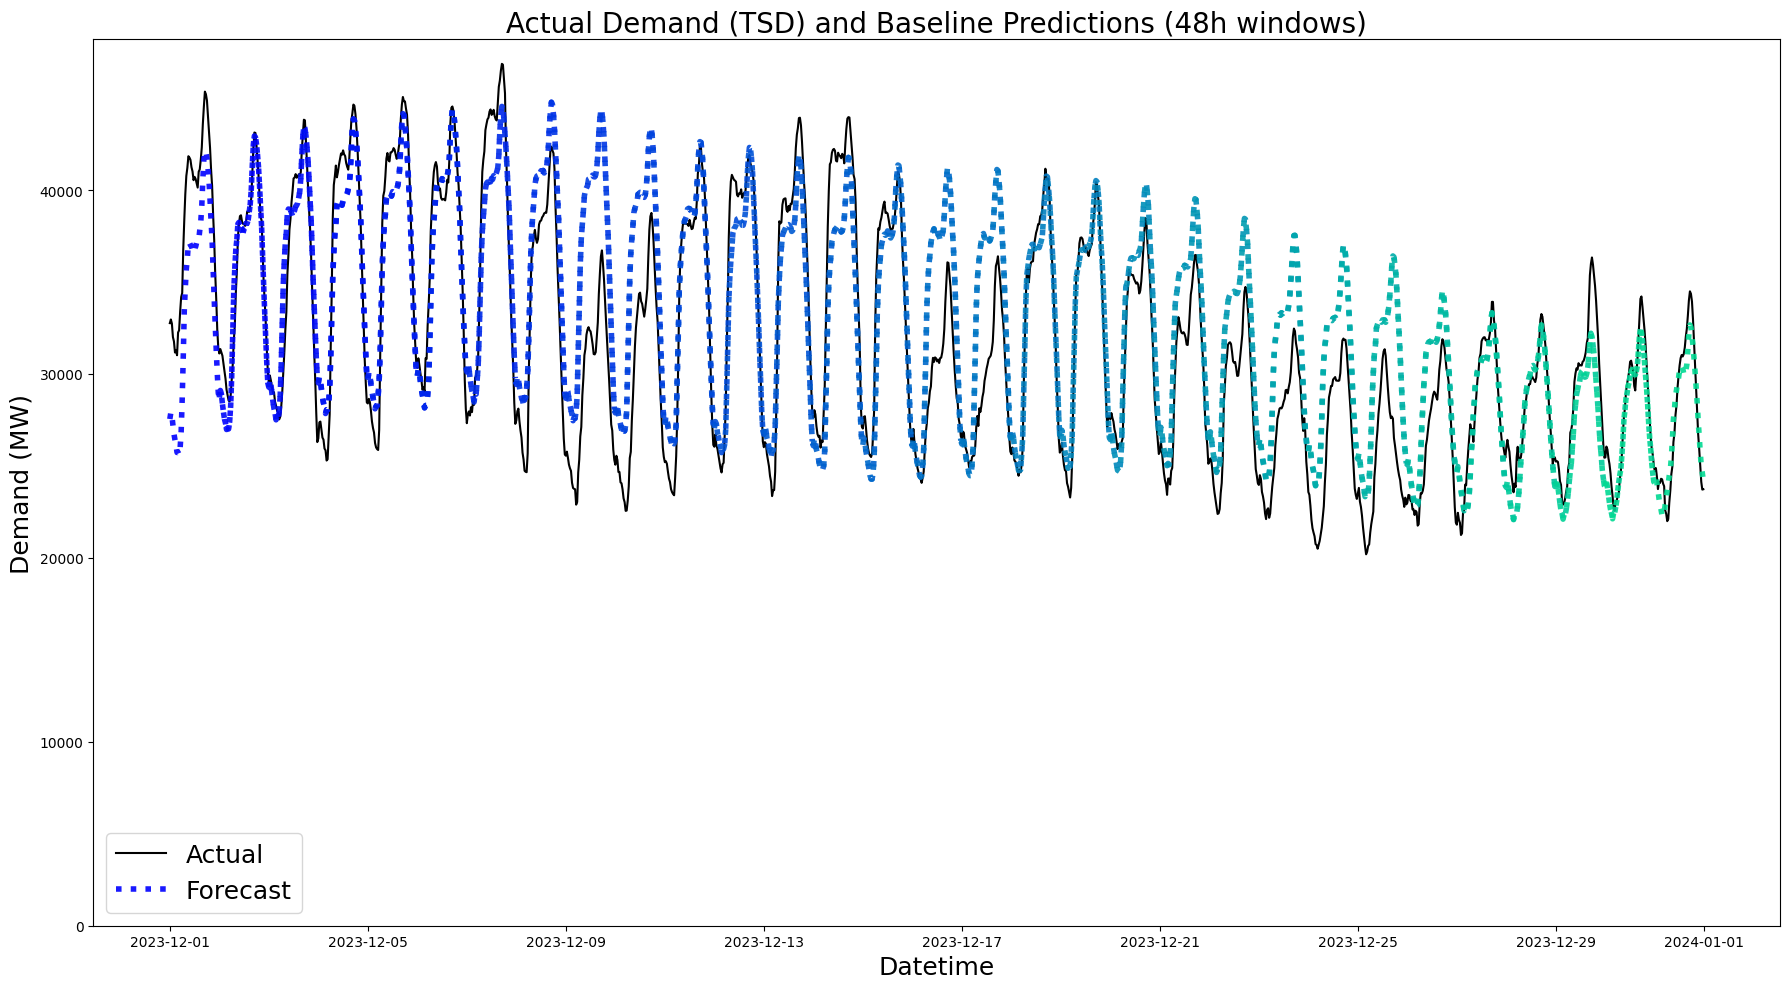

In [ ]:
# Vizualize baseline model predictions
print("Calculating baseline predictions...")
time_start = time.time()
results_baseline, first_window_baseline = rolling_window_predictions(
    df_december, test_start, test_end, 24, 24, baseline_predict_func, cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and Baseline Predictions (24h windows)"
)
baseline_time = time.time() - time_start


In [15]:
# Print the scores
results_baseline_pd = pd.DataFrame(results_baseline)
baseline_rmse = results_baseline_pd['rmse'].mean()
baseline_mape = results_baseline_pd['mape'].mean()


print(f"   🔢 Time period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}\n")
print(f"   ⏱️  Calculation time: {baseline_time:.2f} seconds")
print(f"   📊 RMSE: {baseline_rmse:.2f} MW, MAPE: {baseline_mape:.3f}%")

   🔢 Time period: 2023-12-01 to 2023-12-31

   ⏱️  Calculation time: 15.94 seconds
   📊 RMSE: 2840.05 MW, MAPE: 0.080%


**ML models' predictions**

In [ ]:
# De


df_ml = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd"),

        # Time-based features both in linear and cyclical forms
        pl.col("datetime").dt.hour().alias("hour"),                # 0-23
        (2 * np.pi * pl.col("datetime").dt.hour() / 24).sin().alias("hour_sin"),  # 24-hour cycle
        (2 * np.pi * pl.col("datetime").dt.hour() / 24).cos().alias("hour_cos"),  # 24-hour cycle

        pl.col("datetime").dt.weekday().alias("day_of_week"),      # 0=Monday, 6=Sunday
        (2 * np.pi * pl.col("datetime").dt.weekday() / 7).sin().alias("weekday_sin"), # 7-day cycle
        (2 * np.pi * pl.col("datetime").dt.weekday() / 7).cos().alias("weekday_cos"), # 7-day cycle
        (pl.col("datetime").dt.weekday() >= 5).cast(pl.Int8).alias("is_weekend"),

        
        pl.col("datetime").dt.ordinal_day().alias("day_of_year"),  # 1-366
        (2 * np.pi * pl.col("datetime").dt.ordinal_day() / 365).sin().alias("day_of_year_sin"), # 365-day cycle
        (2 * np.pi * pl.col("datetime").dt.ordinal_day() / 365).cos().alias("day_of_year_cos"), # 365-day cycle
    
        pl.col("tsd").shift(48).alias("demand_lag_24h"),             # D
        pl.col("tsd").shift(96).alias("demand_lag_48h"),            # Demand 48 hours prior
        pl.col("tsd").shift(672).alias("demand_lag_7d"),           # Demand 7 days prior
        pl.col("tsd").shift(3360).alias("demand_lag_14d"),         # Demand 14 days prior
        pl.col("tsd").shift(17520).alias("demand_lag_1y"),  # Demand 1 year (365 days) prior


        pl.col("is_holiday").alias("is_holiday")
    ])
)

In [17]:
# Initialize of GradientBoostingRegressor model
model_gbr = GradientBoostingRegressor(
    n_estimators=200, max_depth=10, learning_rate=0.05, validation_fraction=0.1, random_state=7
    )

# Define features and targets
features_temp = ["hour", "day_of_week", "is_weekend", "day_of_year"]
features_temp_cyclic = [
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",
    "day_of_year_sin", "day_of_year_cos",
    "is_weekend"
]
features_2d_lag = ["demand_lag_48h"]
features_all_lags = ["demand_lag_48h", "demand_lag_7d", "demand_lag_14d", "demand_lag_1y"]
features_holiday = ["is_holiday"]

features_gbr = features_temp_cyclic + features_all_lags + features_holiday

target = "tsd"

In [18]:
# Prepare feature matrices and target vector
X_gbr = df_ml.select(features_gbr)
y = df_ml.select(target)

# Prepare training data
train_mask = (df_ml["datetime"] >= train_start) & (df_ml["datetime"] < test_start)

X_gbr_train = X_gbr.filter(train_mask).to_pandas()

y_train = y.filter(train_mask).to_numpy().ravel()

In [19]:
# Train Gradient Boosting Regressor model
print("Training regular GBR model...")
time_start = time.time()



model_gbr.fit(X_gbr_train, y_train)
print("Regular GBR training completed.")

gbr_regular_time = time.time() - time_start

Training regular GBR model...
Regular GBR training completed.


In [20]:
# Prediction function for model
def ml_predict_func(model, test_df, feature_names,  times):
    X_test = test_df[feature_names].to_pandas()
    return model.predict(X_test)


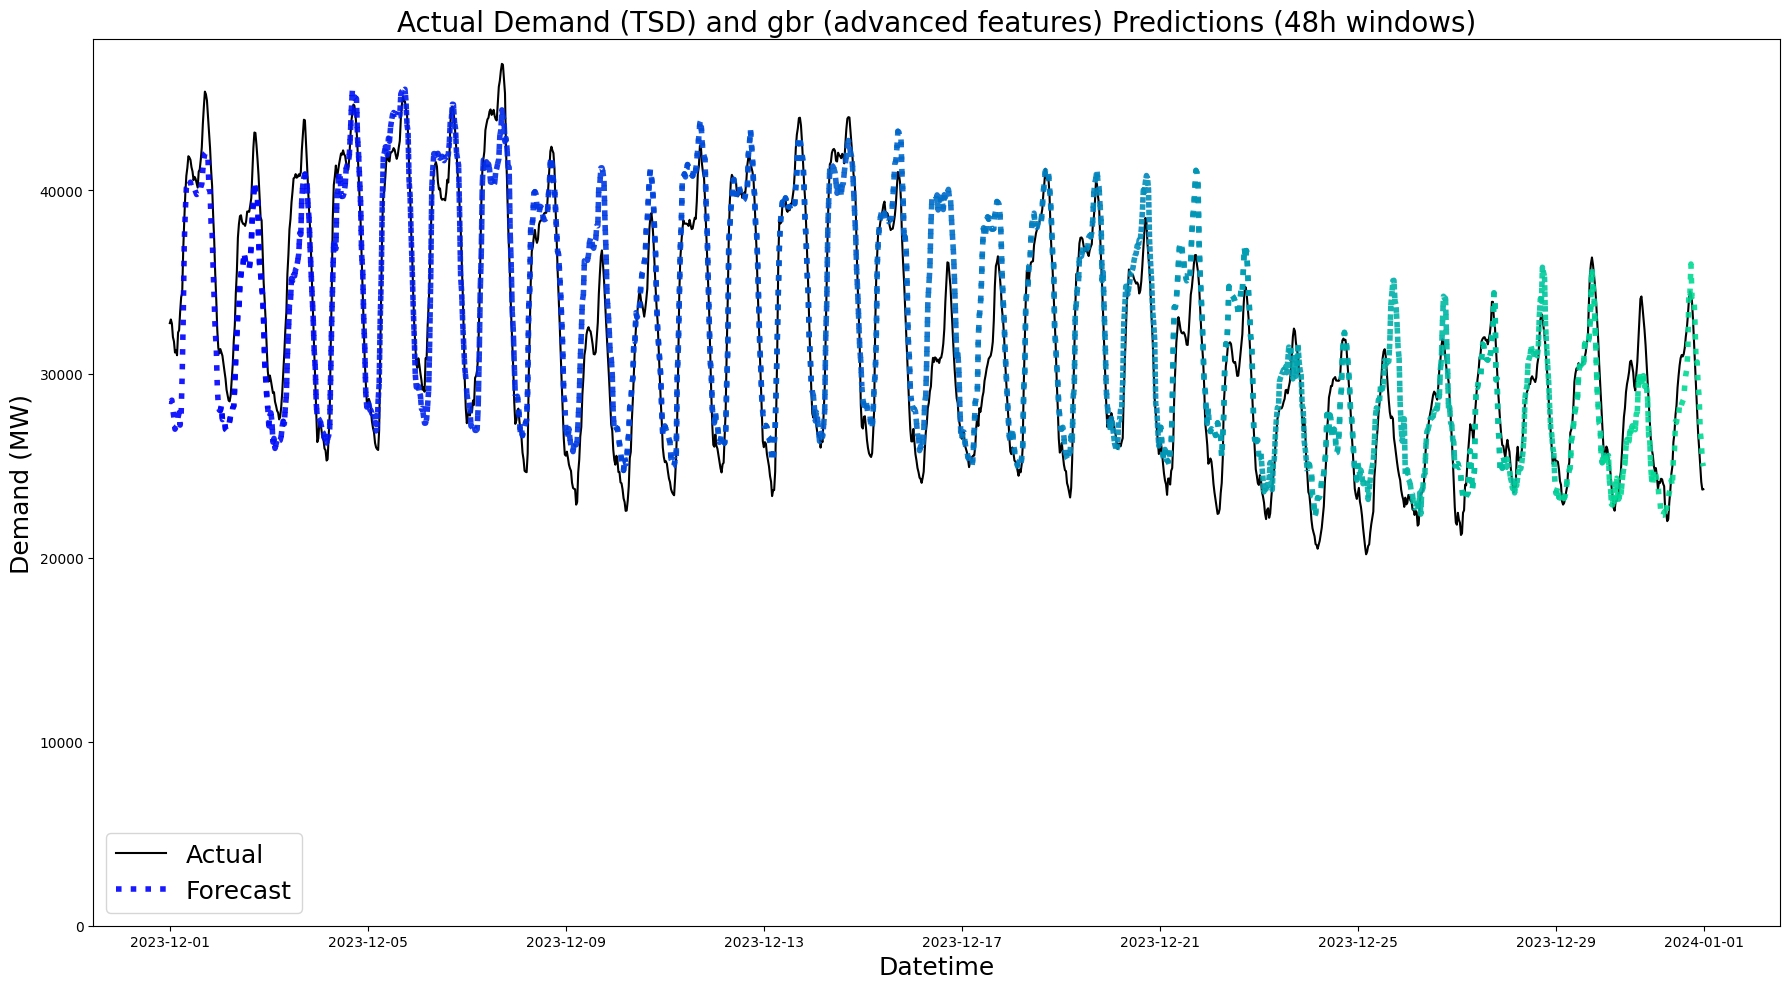

In [21]:
# Run rolling predictions for advanced model
results_gbr, first_window_gbr = rolling_window_predictions(
    df_ml, test_start, test_end, 48, 24,
    lambda test_df, times: ml_predict_func(model_gbr, test_df, features_gbr, times),
    cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and gbr (advanced features) Predictions (48h windows)"
)


In [22]:
# Calculate and store results for regular GBR model
results_gbr_pd = pd.DataFrame(results_gbr)
gbr_regular_rmse = results_gbr_pd['rmse'].mean()
gbr_regular_mape = results_gbr_pd['mape'].mean()

print(f"   🔢 Training period: {train_start.strftime('%Y-%m-%d')} to {(test_start - timedelta(days=1)).strftime('%Y-%m-%d')}")
print(f"   ⏱️  Training time: {gbr_regular_time:.2f} seconds\n")

print(f"   🔢 Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
print(f"   📊 RMSE: {gbr_regular_rmse:.2f} MW, MAPE: {gbr_regular_mape:.3f}%")

if 'results' not in globals():
    results = {}

results['Regular_GBR'] = {
    'model': model_gbr,
    'training_time': gbr_regular_time,
    'rmse': gbr_regular_rmse,
    'mape': gbr_regular_mape
}

   🔢 Training period: 2018-02-01 to 2023-11-30
   ⏱️  Training time: 76.30 seconds

   🔢 Test period: 2023-12-01 to 2023-12-31
   📊 RMSE: 2258.14 MW, MAPE: 0.060%


## Forecast comparison: the first 48h window 

## Forecast comparison: RMSE throught the whole month of December 2023

In [24]:

# Make x axis go from 1 to 31 (all December days)
x_days = list(range(1, 32))

# Prepare y values for each model, filling missing days with None for gaps
def fill_rmse_by_day(results_df):
    rmse_by_day = {d.day: v for d, v in zip(results_df["test_start"], results_df["rmse"])}
    return [rmse_by_day.get(day, None) for day in x_days]

y_7d = fill_rmse_by_day(pd.DataFrame(results_baseline))
y_gbr = fill_rmse_by_day(pd.DataFrame(results_gbr))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_7d,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color='#ff7f0e')
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_gbr,
    mode='lines+markers',
    name='Gradient Boosting Regressor (gbr)',
    line=dict(color='#2ca02c')
))

fig.update_layout(
    title="Comparison of different energy demand forecasting methods for December 2023 in the UK",
    xaxis_title="Day of December",
    yaxis_title="RMSE (MW)",
    plot_bgcolor='whitesmoke',
    legend=dict(
        font=dict(size=18),
        x=1,
        y=1,
        xanchor='right',
        yanchor='top'
    ),
    title_font=dict(size=20),
    title_x=0.5,
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        range=[0.1, 31],
        tickfont=dict(size=16),
        title_font=dict(size=18)
    ),
    yaxis=dict(
        range=[0, 6999],
        tickfont=dict(size=16), 
        title_font=dict(size=18)
        ),
    width=1100,
    height=500
)

fig.show()

## Feature Importance

In [25]:
# Test functions for feature importance plot and values
def test_feature_importance_plot(model, features):
    importances = model.feature_importances_
    feature_names = features

    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_names, sorted_importances, color='dodgerblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances for gbr (5 features)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Verify normalized importance values
def test_feature_importance_values(model, features):
    importances = model.feature_importances_
    assert len(importances) == len(features)
    assert np.isclose(importances.sum(), 1.0)

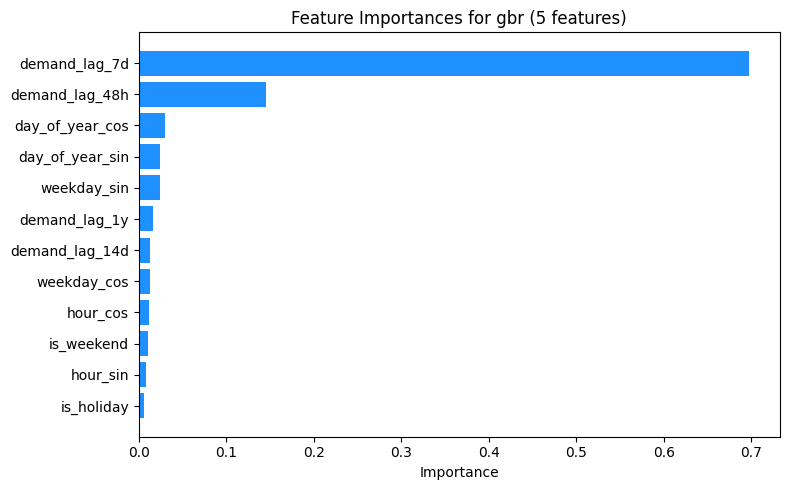

In [26]:
# Feature importance test for model 5
test_feature_importance_plot(model_gbr, features_gbr)
test_feature_importance_values(model_gbr, features_gbr)

## Conclusions:

**Lagged demand features are the most important**: Including demand_lag_30m (previous 30 min) and to a lesser extend demand_lag_24h (previous day) as features improves the model's ability to forecast demand, as shown by the lower RMSE and MAPE for the GBR models compared to the baseline.

**Temporal features help:** Features like day_of_week, hour, and day_of_year capture seasonality and daily/weekly cycles, which are important for electricity demand forecasting.

**Model performance improves with more features:** The GBR model with 5 features outperforms the one with only 3, indicating that additional temporal and lagged features add predictive value. 

**Baseline is outperformed:** Both GBR models provide better accuracy than the simple 7-day mean baseline, demonstrating the value of machine learning and feature engineering for this task.

## Multi-Step Forecasting with Last Known Value

In this section, we'll modify the approach to:
1. Use the last known value as an additional feature
2. Predict 96 consecutive values (48 hours) from a single input point

In [40]:
# Prepare data for multi-step forecasting using Polars for efficiency
def prepare_multistep_data_polars(df_ml, n_steps=96):
    """
    Prepare data for multi-step forecasting using Polars for speed.
    
    For each 23:30 timestamp t, predict the next 96 future values: t+1, t+2, ..., t+96
    
    Key insight: Since we're predicting multiple time steps, we need to create 
    feature matrices where each row represents one prediction horizon, and each
    column represents features for that specific time step.
    
    This means for each input timestamp t (23:30), we create 96 feature vectors:
    - For prediction t+1 (00:00 next day): features at t+1 time
    - For prediction t+2 (00:30 next day): features at t+2 time
    - ...
    - For prediction t+96 (23:30 day after): features at t+96 time
    """
    
    # Filter to only include 23:30 timestamps (last half-hour of each day)
    df_midnight_only = df_ml.filter(
        (pl.col("datetime").dt.hour() == 23) & 
        (pl.col("datetime").dt.minute() == 30)
    )
    
    print(f"Found {len(df_midnight_only)} midnight (23:30) input points")
    
    # We'll create a different structure: for each midnight point, create 96 feature-target pairs
    all_features = []
    all_targets = []
    all_input_timestamps = []
    
    for row in df_midnight_only.iter_rows(named=True):
        input_timestamp = row['datetime']
        last_known_value = row['tsd']  # The demand at 23:30 (last known)
        
        # For this input timestamp, create 96 prediction horizons
        horizon_features = []
        horizon_targets = []
        
        for h in range(1, n_steps + 1):
            # Calculate the target timestamp (h steps ahead)
            target_timestamp = input_timestamp + pd.Timedelta(minutes=30*h)
            
            # Find the row in the full dataset for this target timestamp
            target_row = df_ml.filter(pl.col("datetime") == target_timestamp)
            
            if len(target_row) == 0:
                # If we can't find this timestamp, skip this horizon
                continue
                
            target_row_dict = target_row.to_dicts()[0]
            
            # Create features for this specific horizon
            # These are time-based features for the target timestamp
            # Convert all values to float to ensure proper data types
            features_for_horizon = [
                float(target_row_dict['hour_sin']),
                float(target_row_dict['hour_cos']), 
                float(target_row_dict['weekday_sin']),
                float(target_row_dict['weekday_cos']),
                float(target_row_dict['day_of_year_sin']),
                float(target_row_dict['day_of_year_cos']),
                float(target_row_dict['is_weekend']),
                float(target_row_dict['demand_lag_48h']) if target_row_dict['demand_lag_48h'] is not None else np.nan,
                float(target_row_dict['demand_lag_7d']) if target_row_dict['demand_lag_7d'] is not None else np.nan,
                float(target_row_dict['demand_lag_14d']) if target_row_dict['demand_lag_14d'] is not None else np.nan,
                float(target_row_dict['demand_lag_1y']) if target_row_dict['demand_lag_1y'] is not None else np.nan,
                float(target_row_dict['is_holiday']),
                float(last_known_value),  # This is the same for all horizons (demand at 23:30)
                float(h)  # Add horizon as a feature (1 to 96)
            ]
            
            horizon_features.append(features_for_horizon)
            horizon_targets.append(float(target_row_dict['tsd']))
        
        # Only include if we have complete 96-step predictions
        if len(horizon_features) == n_steps:
            all_features.extend(horizon_features)
            all_targets.extend(horizon_targets)
            all_input_timestamps.extend([input_timestamp] * n_steps)
    
    # Convert to numpy arrays with explicit dtype
    X_features = np.array(all_features, dtype=np.float64)
    y_targets = np.array(all_targets, dtype=np.float64)
    timestamps = all_input_timestamps
    
    print(f"Created {len(X_features)} feature-target pairs from {len(df_midnight_only)} input points")
    print(f"Feature shape: {X_features.shape}")
    print(f"Feature dtype: {X_features.dtype}")
    print(f"Target dtype: {y_targets.dtype}")
    
    return X_features, y_targets, timestamps

print("Preparing multi-step forecasting data with Polars...")
print("Note: Using only 23:30 timestamps as input points to predict next 48 hours")
print("Creating separate feature vectors for each prediction horizon")

Preparing multi-step forecasting data with Polars...
Note: Using only 23:30 timestamps as input points to predict next 48 hours
Creating separate feature vectors for each prediction horizon


In [ ]:
# Function to make 48-hour predictions from a 23:30 timestamp
def predict_48h_from_midnight(model, df_ml, input_timestamp, feature_names):
    """
    Make 48-hour predictions from a given 23:30 timestamp.
    
    Args:
        model: Trained LightGBM model
        df_ml: DataFrame with all features
        input_timestamp: The 23:30 timestamp to predict from
        feature_names: List of feature column names
    
    Returns:
        predictions: Array of 96 predicted values
        pred_timestamps: Array of timestamps for predictions
    """
    
    # Get the last known value (demand at 23:30)
    input_row = df_ml.filter(pl.col("datetime") == input_timestamp)
    if len(input_row) == 0:
        raise ValueError(f"No data found for input timestamp {input_timestamp}")
    
    last_known_value = input_row.to_dicts()[0]['tsd']
    
    # Create feature vectors for each of the 96 prediction horizons
    prediction_features = []
    pred_timestamps = []
    
    for h in range(1, 97):  # 1 to 96 steps ahead
        # Calculate the target timestamp
        target_timestamp = input_timestamp + pd.Timedelta(minutes=30*h)
        pred_timestamps.append(target_timestamp)
        
        # Find the row for this target timestamp to get time-based features and lags
        target_row = df_ml.filter(pl.col("datetime") == target_timestamp)
        
        if len(target_row) == 0:
            # If timestamp not found, create approximate features
            # This shouldn't happen in normal cases but good to handle
            raise ValueError(f"No data found for target timestamp {target_timestamp}")
        
        target_row_dict = target_row.to_dicts()[0]
        
        # Create feature vector for this horizon with explicit type conversion
        features_for_horizon = [
            float(target_row_dict['hour_sin']),
            float(target_row_dict['hour_cos']), 
            float(target_row_dict['weekday_sin']),
            float(target_row_dict['weekday_cos']),
            float(target_row_dict['day_of_year_sin']),
            float(target_row_dict['day_of_year_cos']),
            float(target_row_dict['is_weekend']),
            float(target_row_dict['demand_lag_48h']) if target_row_dict['demand_lag_48h'] is not None else np.nan,
            float(target_row_dict['demand_lag_7d']) if target_row_dict['demand_lag_7d'] is not None else np.nan,
            float(target_row_dict['demand_lag_14d']) if target_row_dict['demand_lag_14d'] is not None else np.nan,
            float(target_row_dict['demand_lag_1y']) if target_row_dict['demand_lag_1y'] is not None else np.nan,
            float(target_row_dict['is_holiday']),
            float(last_known_value),  # Same for all horizons
            float(h)  # Horizon number
        ]
        
        prediction_features.append(features_for_horizon)
    
    # Convert to DataFrame and make predictions
    X_pred = pd.DataFrame(prediction_features, columns=feature_names)
    predictions = model.predict(X_pred)
    
    return predictions, pred_timestamps

# Test the prediction function with the first test example
if len(set(timestamps_test_lightgbm)) > 0:
    # Get the first unique test timestamp (should be Nov 30, 2023 23:30)
    test_input_timestamps = sorted(set(timestamps_test_lightgbm))
    first_test_input = test_input_timestamps[0]
    
    print(f"Making 48-hour prediction from: {first_test_input}")
    
    try:
        predictions, pred_timestamps = predict_48h_from_midnight(
            lgb_model, df_ml, first_test_input, feature_names
        )
        
        print(f"Successfully predicted 96 values")
        print(f"Prediction period: {pred_timestamps[0]} to {pred_timestamps[-1]}")
        print(f"First 5 predictions: {predictions[:5]}")
        print(f"Last 5 predictions: {predictions[-5:]}")
        
        # Compare with actual values for this period
        actual_values = []
        for ts in pred_timestamps:
            actual_row = df_ml.filter(pl.col("datetime") == ts)
            if len(actual_row) > 0:
                actual_values.append(actual_row.to_dicts()[0]['tsd'])
        
        if len(actual_values) == 96:
            example_rmse = root_mean_squared_error(actual_values, predictions)
            example_mape = mean_absolute_percentage_error(actual_values, predictions)
            print(f"Example RMSE: {example_rmse:.2f} MW")
            print(f"Example MAPE: {example_mape:.3f}%")
        
    except Exception as e:
        print(f"Error making prediction: {e}")
else:
    print("No test data available for prediction example")

In [50]:
print("Training LightGBM model for multi-step forecasting...")
time_start = time.time()

# For this approach, we'll use a single LightGBM model instead of MultiOutputRegressor
# since we're treating each horizon as a separate training example
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=7,
    verbose=-1
)

# Define feature names for clarity
feature_names = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", 
    "day_of_year_sin", "day_of_year_cos", "is_weekend",
    "demand_lag_48h", "demand_lag_7d", "demand_lag_14d", "demand_lag_1y",
    "is_holiday", "last_known_value", "horizon"
]

# Prepare data for multi-step forecasting
X_lightgbm, y_lightgbm, timestamps_lightgbm = prepare_multistep_data_polars(df_ml)

print(f"Total training examples: {len(X_lightgbm)}")
if len(timestamps_lightgbm) > 0:
    unique_inputs = len(set(timestamps_lightgbm))
    print(f"Unique input timestamps (23:30): {unique_inputs}")
    print(f"First input timestamp: {timestamps_lightgbm[0]}")
    print(f"Examples per input: {len(X_lightgbm) // unique_inputs if unique_inputs > 0 else 0}")

# Convert timestamps to pandas for easier filtering
timestamps_lightgbm_pd = pd.to_datetime(timestamps_lightgbm)

# Create train/test split using previously defined periods
train_mask_lightgbm = (
    (timestamps_lightgbm_pd >= train_start) & 
    (timestamps_lightgbm_pd < test_start)
)

test_mask_lightgbm = (
    (timestamps_lightgbm_pd >= test_start) & 
    (timestamps_lightgbm_pd <= test_end)
)

# Split the data
X_train_lightgbm = X_lightgbm[train_mask_lightgbm]
y_train_lightgbm = y_lightgbm[train_mask_lightgbm]
X_test_lightgbm = X_lightgbm[test_mask_lightgbm]
y_test_lightgbm = y_lightgbm[test_mask_lightgbm]
timestamps_test_lightgbm = timestamps_lightgbm_pd[test_mask_lightgbm]

print(f"Training examples: {X_train_lightgbm.shape[0]}")
print(f"Test examples: {X_test_lightgbm.shape[0]}")

# Convert to DataFrame for feature names with explicit dtypes
X_train_df = pd.DataFrame(X_train_lightgbm, columns=feature_names, dtype=np.float64)
X_test_df = pd.DataFrame(X_test_lightgbm, columns=feature_names, dtype=np.float64)

print(f"Training DataFrame dtypes: {X_train_df.dtypes.unique()}")
print(f"Test DataFrame dtypes: {X_test_df.dtypes.unique()}")

# Train the model
lgb_model.fit(X_train_df, y_train_lightgbm)
lgb_time = time.time() - time_start

# Evaluate on test data
lgb_pred = lgb_model.predict(X_test_df)
lgb_rmse = root_mean_squared_error(y_test_lightgbm, lgb_pred)
lgb_mape = mean_absolute_percentage_error(y_test_lightgbm, lgb_pred)

# Store results
if 'results' not in globals():
    results = {}

results['LightGBM_Horizon'] = {
    'training_time': lgb_time,
    'rmse': lgb_rmse,
    'mape': lgb_mape,
    'model': lgb_model
}

print(f"   ⏱️  Training time: {lgb_time:.2f} seconds")
print(f"   📊 RMSE: {lgb_rmse:.2f} MW, MAPE: {lgb_mape:.3f}%")
print(f"   🔢 Training period: {train_start.strftime('%Y-%m-%d')} to {(test_start - timedelta(days=1)).strftime('%Y-%m-%d')}")
print(f"   🔢 Test period: {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
print(f"   🕐 Prediction strategy: From 23:30 each day → predict next 48h (00:00 to 23:30 day after)")
print(f"   📊 Model treats each horizon (1-96) as separate training example\n")

Training LightGBM model for multi-step forecasting...
Found 5802 midnight (23:30) input points
Created 553728 feature-target pairs from 5802 input points
Feature shape: (553728, 14)
Feature dtype: float64
Target dtype: float64
Total training examples: 553728
Unique input timestamps (23:30): 5768
First input timestamp: 2009-01-01 23:30:00
Examples per input: 96
Training examples: 2880
Test examples: 2976
Training DataFrame dtypes: [dtype('float64')]
Test DataFrame dtypes: [dtype('float64')]
Created 553728 feature-target pairs from 5802 input points
Feature shape: (553728, 14)
Feature dtype: float64
Target dtype: float64
Total training examples: 553728
Unique input timestamps (23:30): 5768
First input timestamp: 2009-01-01 23:30:00
Examples per input: 96
Training examples: 2880
Test examples: 2976
Training DataFrame dtypes: [dtype('float64')]
Test DataFrame dtypes: [dtype('float64')]
   ⏱️  Training time: 204.49 seconds
   📊 RMSE: 7409.63 MW, MAPE: 0.225%
   🔢 Training period: 2023-11-01

In [43]:
# Create rolling 48-hour window predictions for all of December 2023
def create_lgb_rolling_predictions():
    """
    Create rolling 48-hour predictions for LightGBM model throughout December 2023
    """
    results_lgb = []
    times_list = []
    preds_list = []
    
    # Start from December 1, 2023 and create 48-hour windows every 24 hours
    current_start = test_start
    
    while current_start + pd.Timedelta(hours=48) <= test_end:
        # The input timestamp is 23:30 the day before the prediction window
        input_timestamp = current_start - pd.Timedelta(minutes=30)
        
        print(f"Creating prediction from {input_timestamp.strftime('%Y-%m-%d %H:%M')} for window starting {current_start.strftime('%Y-%m-%d %H:%M')}")
        
        try:
            # Make 48-hour prediction using our trained model
            predictions, pred_timestamps = predict_48h_from_midnight(
                lgb_model, df_ml, input_timestamp, feature_names
            )
            
            # Get actual values for this period
            actual_mask = (df_ml["datetime"] >= current_start) & (df_ml["datetime"] < current_start + pd.Timedelta(hours=48))
            actual_data = df_ml.filter(actual_mask)
            actual_times = actual_data["datetime"].to_pandas()
            actual_values = actual_data["tsd"].to_numpy()
            
            # Align predictions with actual times (should be the same)
            if len(actual_values) == 96 and len(predictions) == 96:
                # Calculate metrics for this window
                rmse = root_mean_squared_error(actual_values, predictions)
                mape = mean_absolute_percentage_error(actual_values, predictions)
                
                results_lgb.append({
                    "test_start": current_start, 
                    "rmse": rmse, 
                    "mape": mape
                })
                
                times_list.append(actual_times)
                preds_list.append(predictions)
                
                print(f"  ✓ Window RMSE: {rmse:.2f} MW, MAPE: {mape:.3f}%")
            else:
                print(f"  ✗ Data mismatch: actual={len(actual_values)}, pred={len(predictions)}")
                
        except Exception as e:
            print(f"  ✗ Error: {e}")
        
        # Move to next 24-hour window
        current_start += pd.Timedelta(hours=24)
    
    return results_lgb, times_list, preds_list

print("Creating rolling 48-hour window predictions for LightGBM model...")
results_lgb_rolling, times_list_lgb, preds_list_lgb = create_lgb_rolling_predictions()

# Plot the rolling predictions
if len(times_list_lgb) > 0:
    plot_rolling_predictions(
        times_list_lgb, preds_list_lgb,
        [actual_future_times], [actual_future_tsd],
        cmap, ['solid', 'dotted'],
        "Actual Demand (TSD) and LightGBM Multi-Step Predictions (48h windows)",
        "Datetime", "Demand (MW)"
    )
    
    # Calculate overall metrics
    results_lgb_pd = pd.DataFrame(results_lgb_rolling)
    lgb_rolling_rmse = results_lgb_pd['rmse'].mean()
    lgb_rolling_mape = results_lgb_pd['mape'].mean()
    
    print(f"\n📊 LightGBM Rolling Window Results:")
    print(f"   📊 Average RMSE: {lgb_rolling_rmse:.2f} MW")
    print(f"   📊 Average MAPE: {lgb_rolling_mape:.3f}%")
    print(f"   📊 Number of windows: {len(results_lgb_rolling)}")
    
    # Store in results for comparison
    results['LightGBM_Rolling'] = {
        'training_time': lgb_time,  # Use same training time
        'rmse': lgb_rolling_rmse,
        'mape': lgb_rolling_mape,
        'model': lgb_model
    }
else:
    print("No rolling predictions were generated.")

Creating rolling 48-hour window predictions for LightGBM model...
Creating prediction from 2023-11-30 23:30 for window starting 2023-12-01 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-01 23:30 for window starting 2023-12-02 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-02 23:30 for window starting 2023-12-03 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-03 23:30 for window starting 2023-12-04 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-04 23:30 for window starting 2023-12-05 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-05 23:30 for window starting 2023-12-06 00:00
  ✗ Error: name 'predict_48h_from_midnight' is not defined
Creating prediction from 2023-12-06 23:30 for window starting 2023-12-07 00:00
  ✗ Error: name 'predict_48

In [47]:
# Compare RMSE across all three models for December 2023
if len(results_lgb_rolling) > 0:
    # Make x axis go from 1 to 31 (all December days)
    x_days = list(range(1, 32))
    
    # Prepare y values for each model, filling missing days with None for gaps
    def fill_rmse_by_day(results_df):
        rmse_by_day = {d.day: v for d, v in zip(results_df["test_start"], results_df["rmse"])}
        return [rmse_by_day.get(day, None) for day in x_days]
    
    # Get RMSE values for all models
    y_baseline = fill_rmse_by_day(pd.DataFrame(results_baseline))
    y_gbr = fill_rmse_by_day(pd.DataFrame(results_gbr))
    y_lgb = fill_rmse_by_day(pd.DataFrame(results_lgb_rolling))
    
    # Create comparison plot
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=x_days,
        y=y_baseline,
        mode='lines+markers',
        name='Baseline: 7-day mean',
        line=dict(color='#ff7f0e')
    ))
    
    fig.add_trace(go.Scatter(
        x=x_days,
        y=y_gbr,
        mode='lines+markers',
        name='Gradient Boosting Regressor (GBR)',
        line=dict(color='#2ca02c')
    ))
    
    fig.add_trace(go.Scatter(
        x=x_days,
        y=y_lgb,
        mode='lines+markers',
        name='LightGBM Multi-Step',
        line=dict(color='#1f77b4')
    ))
    
    fig.update_layout(
        title="Comparison of Forecasting Methods: RMSE Throughout December 2023",
        xaxis_title="Day of December",
        yaxis_title="RMSE (MW)",
        plot_bgcolor='whitesmoke',
        legend=dict(
            font=dict(size=16),
            x=1,
            y=1,
            xanchor='right',
            yanchor='top'
        ),
        title_font=dict(size=20),
        title_x=0.5,
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=1,
            range=[0.1, 31],
            tickfont=dict(size=16),
            title_font=dict(size=18)
        ),
        yaxis=dict(
            range=[0, 6999],
            tickfont=dict(size=16), 
            title_font=dict(size=18)
        ),
        width=1200,
        height=600
    )
    
    fig.show()
    
    # Print summary comparison
    print(f"\n🏆 Model Performance Summary (December 2023):")
    print(f"   📊 Baseline (7-day mean):     RMSE: {baseline_rmse:.2f} MW, MAPE: {baseline_mape:.3f}%")
    print(f"   📊 GBR (advanced features):  RMSE: {gbr_regular_rmse:.2f} MW, MAPE: {gbr_regular_mape:.3f}%")
    print(f"   📊 LightGBM Multi-Step:      RMSE: {lgb_rolling_rmse:.2f} MW, MAPE: {lgb_rolling_mape:.3f}%")
    
    # Calculate improvements
    gbr_improvement = ((baseline_rmse - gbr_regular_rmse) / baseline_rmse) * 100
    lgb_improvement = ((baseline_rmse - lgb_rolling_rmse) / baseline_rmse) * 100
    
    print(f"\n📈 Improvements over Baseline:")
    print(f"   📊 GBR improvement:     {gbr_improvement:.1f}% reduction in RMSE")
    print(f"   📊 LightGBM improvement: {lgb_improvement:.1f}% reduction in RMSE")
    
    if lgb_rolling_rmse < gbr_regular_rmse:
        lgb_vs_gbr = ((gbr_regular_rmse - lgb_rolling_rmse) / gbr_regular_rmse) * 100
        print(f"   📊 LightGBM vs GBR:     {lgb_vs_gbr:.1f}% better than GBR")
    else:
        gbr_vs_lgb = ((lgb_rolling_rmse - gbr_regular_rmse) / lgb_rolling_rmse) * 100
        print(f"   📊 GBR vs LightGBM:     {gbr_vs_lgb:.1f}% better than LightGBM")

In [48]:
# Plot the first 48h window comparison including LightGBM
if len(times_list_lgb) > 0 and len(results_lgb_rolling) > 0:
    # Get the first window data for LightGBM
    first_window_lgb_times = times_list_lgb[0]
    first_window_lgb_preds = preds_list_lgb[0]
    
    # Prepare data for the first 48h window (get data from existing baseline and GBR)
    # Use the same times as baseline for consistency
    actual_times = first_window_baseline["datetime"]
    actual_values = df_ml.filter(
        (df_ml["datetime"] >= actual_times.iloc[0]) & (df_ml["datetime"] <= actual_times.iloc[-1])
    )["tsd"].to_numpy()
    
    # Forecasts for the first 48h window
    baseline_pred = first_window_baseline["prediction"]
    gbr_pred = first_window_gbr["prediction"]
    
    # Plotly colors
    color_baseline = '#ff7f0e'
    color_gbr_advanced = '#2ca02c'
    color_lgb = '#1f77b4'
    
    fig = go.Figure()
    
    # Actual (solid black)
    fig.add_trace(go.Scatter(
        x=actual_times,
        y=actual_values,
        mode='lines',
        name='Actual',
        line=dict(color='black', width=2, dash='solid')
    ))
    
    # Baseline forecast (dotted)
    fig.add_trace(go.Scatter(
        x=actual_times,
        y=baseline_pred,
        mode='lines+markers',
        name='Baseline: 7-day mean',
        line=dict(color=color_baseline, width=3, dash='dot'),
        marker=dict(color=color_baseline, size=4)
    ))
    
    # GBR advanced features (dotted)
    fig.add_trace(go.Scatter(
        x=actual_times,
        y=gbr_pred,
        mode='lines+markers',
        name='GBR (advanced features)',
        line=dict(color=color_gbr_advanced, width=3, dash='dot'),
        marker=dict(color=color_gbr_advanced, size=4)
    ))
    
    # LightGBM multi-step (dotted)
    fig.add_trace(go.Scatter(
        x=first_window_lgb_times,
        y=first_window_lgb_preds,
        mode='lines+markers',
        name='LightGBM Multi-Step',
        line=dict(color=color_lgb, width=3, dash='dot'),
        marker=dict(color=color_lgb, size=4)
    ))
    
    fig.update_layout(
        title="First 48h Window: Actual vs All Forecasting Methods",
        xaxis_title="Datetime",
        yaxis_title="Demand (MW)",
        title_font=dict(size=20),
        title_x=0.5,
        plot_bgcolor='whitesmoke',
        legend=dict(font=dict(size=16)),
        width=1200,
        height=600,
        xaxis=dict(tickfont=dict(size=14), title_font=dict(size=16)),
        yaxis=dict(tickfont=dict(size=14), title_font=dict(size=16))
    )
    
    fig.show()
    
    # Calculate metrics for the first window for all models
    first_window_metrics = {}
    
    # Baseline metrics
    baseline_rmse_first = root_mean_squared_error(actual_values, baseline_pred)
    baseline_mape_first = mean_absolute_percentage_error(actual_values, baseline_pred)
    first_window_metrics['Baseline'] = {'rmse': baseline_rmse_first, 'mape': baseline_mape_first}
    
    # GBR metrics  
    gbr_rmse_first = root_mean_squared_error(actual_values, gbr_pred)
    gbr_mape_first = mean_absolute_percentage_error(actual_values, gbr_pred)
    first_window_metrics['GBR'] = {'rmse': gbr_rmse_first, 'mape': gbr_mape_first}
    
    # LightGBM metrics
    lgb_rmse_first = root_mean_squared_error(actual_values, first_window_lgb_preds)
    lgb_mape_first = mean_absolute_percentage_error(actual_values, first_window_lgb_preds)
    first_window_metrics['LightGBM'] = {'rmse': lgb_rmse_first, 'mape': lgb_mape_first}
    
    # Print first window comparison
    print(f"\n📊 First 48h Window Performance Comparison:")
    for model_name, metrics in first_window_metrics.items():
        print(f"   📊 {model_name:20}: RMSE: {metrics['rmse']:.2f} MW, MAPE: {metrics['mape']:.3f}%")
    
    # Find best model for first window
    best_model = min(first_window_metrics.items(), key=lambda x: x[1]['rmse'])
    print(f"\n🏆 Best model for first window: {best_model[0]} (RMSE: {best_model[1]['rmse']:.2f} MW)")
    
else:
    print("No LightGBM rolling predictions available for first window plot")

No LightGBM rolling predictions available for first window plot


In [29]:
# Create train/test split for multi-step forecasting
timestamps_multistep_pd = pd.to_datetime(timestamps_multistep)

# Filter to only use data from Jan 1, 2018 onwards for training
# Training period: Jan 1, 2018 to Nov 30, 2023 23:30
train_mask_multistep = (
    (timestamps_multistep_pd >= pd.Timestamp("2018-01-01 00:00:00")) & 
    (timestamps_multistep_pd < pd.Timestamp("2023-11-30 23:30:00"))
)

# Test period: Nov 30, 2023 23:30 onwards
test_mask_multistep = timestamps_multistep_pd >= pd.Timestamp("2023-11-30 23:30:00")

X_train_multistep = X_multistep[train_mask_multistep]
y_train_multistep = y_multistep[train_mask_multistep]
X_test_multistep = X_multistep[test_mask_multistep]
y_test_multistep = y_multistep[test_mask_multistep]
timestamps_test_multistep = timestamps_multistep_pd[test_mask_multistep]

print(f"Training samples: {X_train_multistep.shape[0]}")
print(f"Test samples: {X_test_multistep.shape[0]}")
print(f"Training period: 2018-01-01 to 2023-11-30 23:30")
print(f"First test timestamp: {timestamps_test_multistep[0] if len(timestamps_test_multistep) > 0 else 'None'}")
print(f"Last test timestamp: {timestamps_test_multistep[-1] if len(timestamps_test_multistep) > 0 else 'None'}")

NameError: name 'timestamps_multistep' is not defined

In [ ]:
# Compare multi-step forecasting approaches
print("🚀 Multi-Step Forecasting Model Comparison")
print("=" * 50)

for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"   ⏱️  Training time: {result['training_time']:.2f} seconds")
    print(f"   📊 RMSE: {result['rmse']:.2f} MW")
    print(f"   📊 MAPE: {result['mape']:.3f}%")
    print()

# Find the fastest and most accurate models
fastest_model = min(results.items(), key=lambda x: x[1]['training_time'])
most_accurate_model = min(results.items(), key=lambda x: x[1]['rmse'])

print(f"🚀 FASTEST: {fastest_model[0]} ({fastest_model[1]['training_time']:.2f}s)")
print(f"🎯 MOST ACCURATE: {most_accurate_model[0]} (RMSE: {most_accurate_model[1]['rmse']:.2f} MW)")

# Calculate speed improvement
if len(results) > 1:
    model_times = [result['training_time'] for result in results.values()]
    speed_improvement = max(model_times) / min(model_times)
    print(f"⚡ Speed improvement: {speed_improvement:.1f}x faster")

In [ ]:
# Example prediction: Using demand on Nov 30, 2023 at 23:30 to predict Dec 1-2, 2023
if len(X_test_multistep) > 0:
    # Take the first test sample (this represents Nov 30, 2023 23:30)
    example_features = X_test_multistep[0:1]  # Shape: (1, 13)
    example_prediction = multistep_model.predict(example_features)  # Shape: (1, 96)
    
    # Generate timestamps for the 96 predicted values
    start_time = pd.Timestamp("2023-12-01 00:00:00")
    predicted_timestamps = pd.date_range(start_time, periods=96, freq='30min')
    
    print(f"Input timestamp: Nov 30, 2023 23:30")
    print(f"Last known value: {example_features[0][-1]:.2f} MW")
    print(f"Predicted 96 values from: {predicted_timestamps[0]} to {predicted_timestamps[-1]}")
    print(f"First 5 predictions: {example_prediction[0][:5]}")
    print(f"Last 5 predictions: {example_prediction[0][-5:]}")
    
    # Create a DataFrame for the example prediction
    example_df = pd.DataFrame({
        'datetime': predicted_timestamps,
        'predicted_demand': example_prediction[0]
    })
    
    print(f"\\nPrediction DataFrame shape: {example_df.shape}")
    print(example_df.head())

Input timestamp: Nov 30, 2023 23:30
Last known value: 33503.00 MW
Predicted 96 values from: 2023-12-01 00:00:00 to 2023-12-02 23:30:00
First 5 predictions: [32467.3730325  32016.82549752 31967.56745761 31532.14560656
 31155.78886714]
Last 5 predictions: [34469.55221266 32868.2973976  32119.04053476 30150.5352532
 29703.21304987]
\nPrediction DataFrame shape: (96, 2)
             datetime  predicted_demand
0 2023-12-01 00:00:00      32467.373033
1 2023-12-01 00:30:00      32016.825498
2 2023-12-01 01:00:00      31967.567458
3 2023-12-01 01:30:00      31532.145607
4 2023-12-01 02:00:00      31155.788867


In [ ]:
# Evaluate the multi-step model on test data
def evaluate_multistep_model(model, X_test, y_test, timestamps_test):
    """Evaluate multi-step forecasting model"""
    
    if len(X_test) == 0:
        print("No test data available")
        return None
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics for each horizon (1 to 96 steps ahead)
    horizon_metrics = []
    for h in range(96):
        y_true_h = y_test[:, h]
        y_pred_h = y_pred[:, h]
        
        rmse_h = root_mean_squared_error(y_true_h, y_pred_h)
        mape_h = mean_absolute_percentage_error(y_true_h, y_pred_h)
        
        horizon_metrics.append({
            'horizon': h + 1,
            'hours_ahead': (h + 1) * 0.5,  # Convert to hours
            'rmse': rmse_h,
            'mape': mape_h
        })
    
    # Calculate overall metrics
    overall_rmse = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    overall_mape = mean_absolute_percentage_error(y_test.flatten(), y_pred.flatten())
    
    print(f"Overall RMSE: {overall_rmse:.2f} MW")
    print(f"Overall MAPE: {overall_mape:.2f}%")
    
    return horizon_metrics, y_pred

# Evaluate the model
print("Evaluating multi-step forecasting model...")
horizon_metrics, predictions_multistep = evaluate_multistep_model(
    multistep_model, X_test_multistep, y_test_multistep, timestamps_test_multistep
)

Evaluating multi-step forecasting model...
Overall RMSE: 2014.33 MW
Overall MAPE: 0.06%


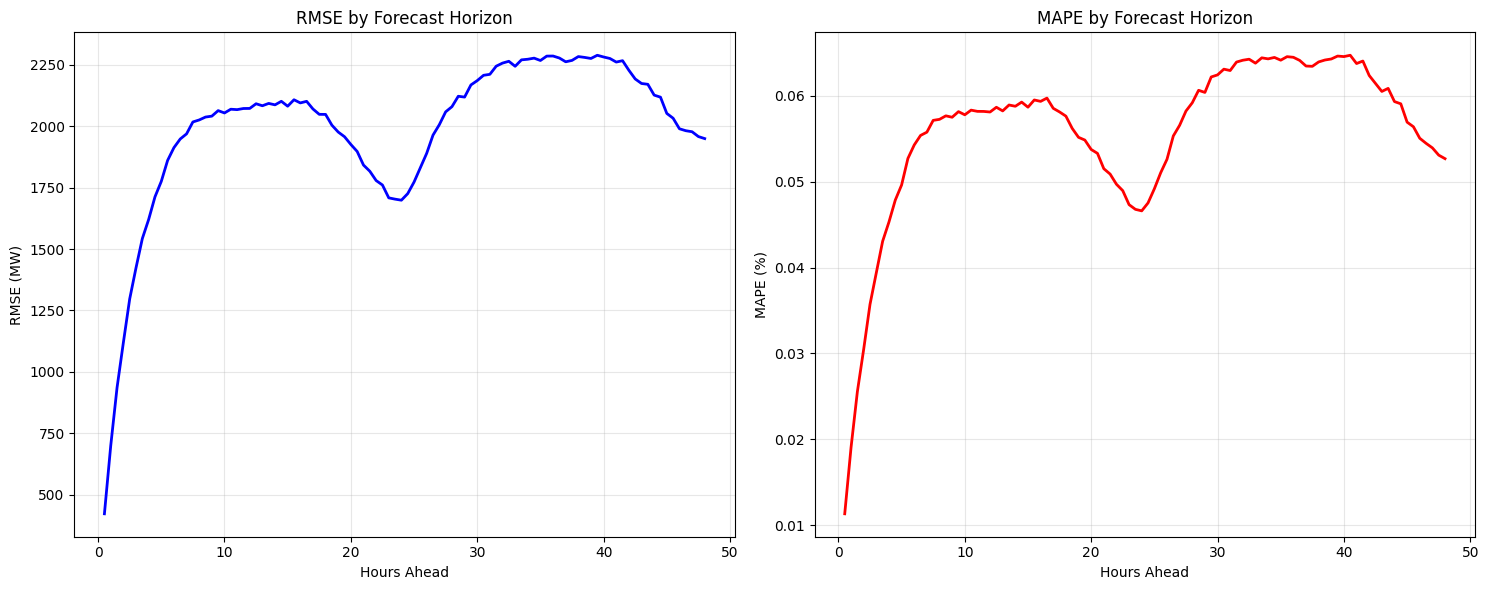

\nForecast Horizon Analysis:
1-hour ahead - RMSE: 699.51 MW, MAPE: 0.02%
12-hour ahead - RMSE: 2072.89 MW, MAPE: 0.06%
24-hour ahead - RMSE: 1699.20 MW, MAPE: 0.05%
48-hour ahead - RMSE: 1950.03 MW, MAPE: 0.05%


In [ ]:
# Plot error metrics by forecast horizon
if horizon_metrics:
    import matplotlib.pyplot as plt
    
    horizon_df = pd.DataFrame(horizon_metrics)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # RMSE by horizon
    ax1.plot(horizon_df['hours_ahead'], horizon_df['rmse'], 'b-', linewidth=2)
    ax1.set_xlabel('Hours Ahead')
    ax1.set_ylabel('RMSE (MW)')
    ax1.set_title('RMSE by Forecast Horizon')
    ax1.grid(True, alpha=0.3)
    
    # MAPE by horizon
    ax2.plot(horizon_df['hours_ahead'], horizon_df['mape'], 'r-', linewidth=2)
    ax2.set_xlabel('Hours Ahead')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('MAPE by Forecast Horizon')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some key statistics
    print(f"\\nForecast Horizon Analysis:")
    print(f"1-hour ahead - RMSE: {horizon_df.iloc[1]['rmse']:.2f} MW, MAPE: {horizon_df.iloc[1]['mape']:.2f}%")
    print(f"12-hour ahead - RMSE: {horizon_df.iloc[23]['rmse']:.2f} MW, MAPE: {horizon_df.iloc[23]['mape']:.2f}%")
    print(f"24-hour ahead - RMSE: {horizon_df.iloc[47]['rmse']:.2f} MW, MAPE: {horizon_df.iloc[47]['mape']:.2f}%")
    print(f"48-hour ahead - RMSE: {horizon_df.iloc[95]['rmse']:.2f} MW, MAPE: {horizon_df.iloc[95]['mape']:.2f}%")

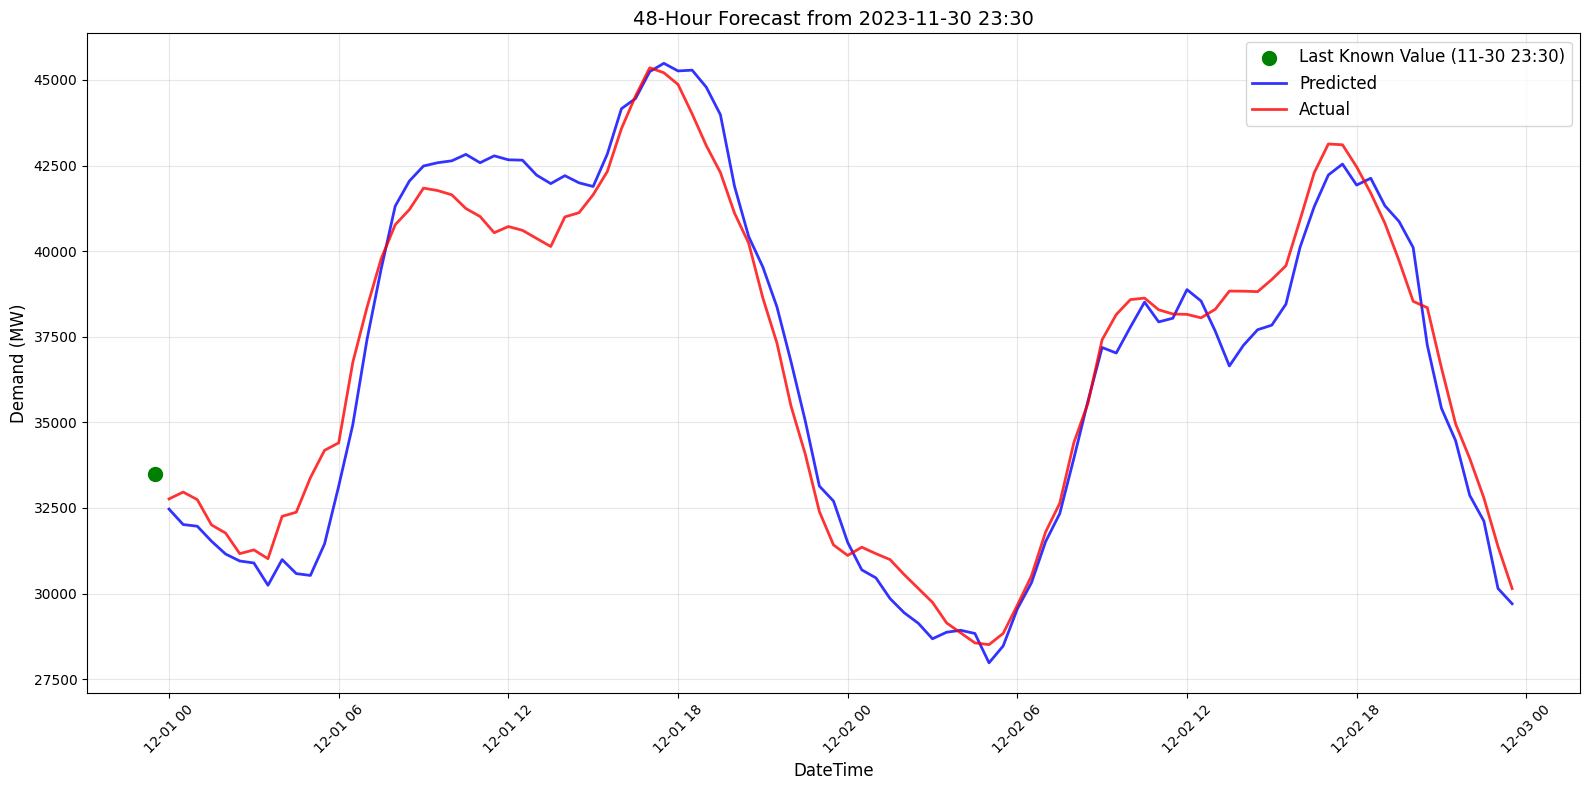

\nExample Prediction Analysis:
Input: 2023-11-30 23:30 (Last known value: 33503.00 MW)
Prediction period: 2023-12-01 00:00 to 2023-12-02 23:30
RMSE: 1070.95 MW
MAPE: 0.02%


In [ ]:
# Visualize a specific example: Nov 30 23:30 -> Dec 1-2 prediction
if len(X_test_multistep) > 0 and predictions_multistep is not None:
    # Use the first test example
    example_idx = 0
    input_timestamp = timestamps_test_multistep[example_idx]
    
    # Generate prediction timestamps (96 half-hour intervals starting from next period)
    pred_start = input_timestamp + pd.Timedelta(minutes=30)
    pred_timestamps = pd.date_range(pred_start, periods=96, freq='30min')
    
    # Get predictions and actual values
    pred_values = predictions_multistep[example_idx]
    actual_values = y_test_multistep[example_idx]
    
    # Get the last known value (input feature)
    last_known_value = X_test_multistep[example_idx][-1]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot last known point
    ax.scatter([input_timestamp], [last_known_value], 
              color='green', s=100, zorder=5, label=f'Last Known Value ({input_timestamp.strftime("%m-%d %H:%M")})')
    
    # Plot predictions and actual values
    ax.plot(pred_timestamps, pred_values, 'b-', linewidth=2, label='Predicted', alpha=0.8)
    ax.plot(pred_timestamps, actual_values, 'r-', linewidth=2, label='Actual', alpha=0.8)
    
    # Formatting
    ax.set_xlabel('DateTime', fontsize=12)
    ax.set_ylabel('Demand (MW)', fontsize=12)
    ax.set_title(f'48-Hour Forecast from {input_timestamp.strftime("%Y-%m-%d %H:%M")}', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics for this specific example
    example_rmse = root_mean_squared_error(actual_values, pred_values)
    example_mape = mean_absolute_percentage_error(actual_values, pred_values)
    
    print(f"\\nExample Prediction Analysis:")
    print(f"Input: {input_timestamp.strftime('%Y-%m-%d %H:%M')} (Last known value: {last_known_value:.2f} MW)")
    print(f"Prediction period: {pred_timestamps[0].strftime('%Y-%m-%d %H:%M')} to {pred_timestamps[-1].strftime('%Y-%m-%d %H:%M')}")
    print(f"RMSE: {example_rmse:.2f} MW")
    print(f"MAPE: {example_mape:.2f}%")

## Ways to improve

**Add weather data:** temperature could be useful to predict heating/cooling associated electricity demands.

**Add more lagged features:** 1h, 3h, 12h, 1 week (and explore which ones are most important).

**Tune hyperparameters:** Use grid search or Bayesian optimization to find the best model parameters.

**Handle special cases:** Daylight saving creates duplicate/missing time intances, which could affect forecasting.

**Ensemble methods:** Combine predictions from multiple models to reduce variance and improve accuracy.


## Alternative Approaches for Multi-Step Forecasting

The current MultiOutputRegressor approach with GBR is slow because it trains 96 separate models. Here are faster and potentially better alternatives:

### 1. **Direct Multi-Step Approaches**
- **LightGBM/XGBoost**: Much faster tree-based models with better performance
- **Linear Models**: Ridge/Lasso regression for speed
- **Neural Networks**: Dense networks that can output 96 values directly

### 2. **Recursive/Iterative Approaches**
- **Single-step model applied recursively**: Train one model, use its output as input for next step
- **Autoregressive models**: Classical time series approaches (ARIMA, VAR)

### 3. **Sequence-to-Sequence Models**
- **LSTM/GRU**: Specialized for time series sequences
- **Transformer models**: State-of-the-art for sequence modeling
- **TCN (Temporal Convolutional Networks)**: Often faster than RNNs

### 4. **Specialized Time Series Models**
- **Prophet**: Facebook's forecasting tool, great for daily/weekly patterns
- **Exponential Smoothing**: Classical statistical methods
- **State Space Models**: Advanced statistical approaches

Let's implement a few of these to compare speed and performance: